In [38]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup, Tag, UnicodeDammit
import re
import sys
import os
import time
import numpy as np
from scipy import spatial
from sklearn.cluster import SpectralClustering

In [92]:
import networkx as nx

In [41]:
import matplotlib
from matplotlib import pyplot as plt

In [56]:
import pickle
from dataReader import *

/Users/driveresearch/anaconda3/lib/python2.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [57]:
with open('../data/processed/movies.pkl', 'rb') as movies_pkl:
    movies = pickle.load(movies_pkl)

In [325]:
gender_dataframe = pd.read_csv('../data/processed/gender_bow.csv')

In [345]:
n = 100
vectors = list(gender_dataframe['vector'][:n])

movies_vector = []
for vector in vectors:
    movies_vector.append([int(x) for x in vector[1:-1].split(',')])
data = np.array(movies_vector)
movies_vector = normalize(data, axis=0, norm='max').tolist()

movie_names = list(gender_dataframe['movie'])
movie_dict = {}
for i in range(n):
    movie_dict[i] = movie_names[i]

adjacency_matrix = [[0] * n]*n
for i in range(len(movies_vector)):
    for j in range(len(movies_vector)):
        if i == j:
            adjacency_matrix[i][j] = 0
            continue
        similarity = 1 - spatial.distance.cosine(movies_vector[i], movies_vector[j])
        if similarity > 0.5:
            adjacency_matrix[i][j] = 1
        else:
            adjacency_matrix[i][j] = 0
adjacency_matrix = np.array(adjacency_matrix)

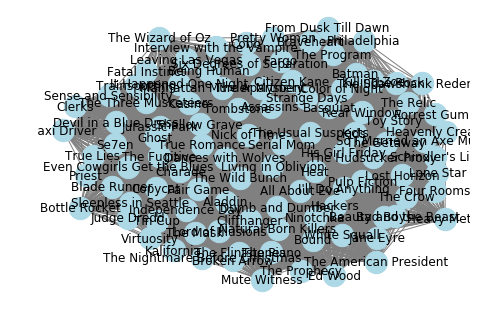

In [346]:
rows, cols = np.where(adjacency_matrix == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges, edge_color='blue')
nx.draw(gr, node_size=500,node_color='lightblue',edge_color='gray', labels=movie_dict, with_labels=True)
plt.show()

In [83]:
clustering = SpectralClustering(n_clusters=10).fit(affinity_matrix)

In [84]:
clusters = {}
for i in range(300):
    movie_name = gender_dataframe['movie'][i]
    label = list(clustering.labels_)[i]
    if label in clusters:
        clusters[label] += [movie_name]
    else:
        clusters[label] = [movie_name]

In [85]:
movie_clusters = {}
for movie in movies:
    for label in clusters:
        if movie.title in clusters[label]:
            if label in movie_clusters:
                movie_clusters[label] += [movie]
            else:
                movie_clusters[label] = [movie]

In [87]:
for label in movie_clusters:
    label_titles = []
    label_genres = set()
    for movie in movie_clusters[label]:
        label_titles.append(movie.title)
        movie_genres = returnGenre(movie.genres)
        label_genres.update(movie_genres)
    print label, list(label_genres) #list(set(label_titles)), 
    print

0 ['Mystery', 'Romance', 'Horror', 'Crime', 'Drama', 'Science Fiction', 'Comedy', 'Documentary', 'Thriller']

1 ['Mystery', 'Romance', 'Family', 'Fantasy', 'Horror', 'Crime', 'Drama', 'Science Fiction', 'Animation', 'Music', 'Adventure', 'Action', 'Comedy', 'War', 'Thriller', 'History']

2 ['Mystery', 'Romance', 'Fantasy', 'Drama', 'Science Fiction', 'Action', 'Comedy', 'War', 'Thriller', 'History']

3 ['Mystery', 'Romance', 'Family', 'Science Fiction', 'Horror', 'Crime', 'Drama', 'Fantasy', 'Western', 'Animation', 'Music', 'Adventure', 'Action', 'Comedy', 'War', 'Thriller', 'History']

4 ['Drama', 'Fantasy', 'Horror', 'Crime', 'Romance', 'Science Fiction', 'Adventure', 'Action', 'Comedy', 'Thriller']

5 ['Action', 'Thriller']

6 ['Mystery', 'Romance', 'Family', 'Horror', 'Crime', 'Drama', 'Fantasy', 'Animation', 'Music', 'Adventure', 'Action', 'TV Movie', 'Comedy', 'Thriller', 'History']

7 ['Mystery', 'Crime', 'Romance', 'Animation', 'Music', 'Foreign', 'Action', 'Comedy', 'Documenta

In [308]:
movies_dict = {}
for movie in movies:
    if movie.title in movie_names:
        bow = list(gender_dataframe[gender_dataframe['movie']==movie.title]['vector'])[0]
        bow = [int(x) for x in bow[1:-1].split(',')]
        num_female = len(movie.cast.get_female_cast())
        num_male = len(movie.cast.get_male_cast())
        if num_male == 0:
            if num_female > 0:
                ratio = 1.0
            else:
                ratio = 0.0
        else:
            ratio = float(num_female)/num_male
        if ratio == 1:
            print movie.title
        #movies_dict[movie.title] = [ratio, bow]

Leaving Las Vegas
Sleepless in Seattle
My Best Friend's Wedding
Anastasia
The Sweet Hereafter
Inventing the Abbotts
April Fool's Day
Fair Game
Swingers
Life
Sense and Sensibility
The Elephant Man
Bound


In [317]:
total_count = 0
greater_count = 0
for movie in movies_dict:
    if movie == 'Anastasia':
        continue
    average_ratio += movies_dict[movie][0]
    bow = movies_dict[movie][1]
    similarity = 1 - spatial.distance.cosine(bow, highest_bow)
    if similarity > 0.95:
        print movie, round(movies_dict[movie][0],3)
        if round(movies_dict[movie][0],3) >= 0.566:
            greater_count += 1
        total_count += 1

My Best Friend's Wedding 1.0
Beloved 2.5
Even Cowgirls Get the Blues 0.875
Scream 2 1.737
Drop Dead Gorgeous 1.714
Scream 0.545
Carrie 1.125
Aliens 0.467
G.I. Jane 0.182
Jane Eyre 0.667
Stepmom 1.667
The Long Kiss Goodnight 0.444
Prom Night 0.6
Heavenly Creatures 1.5
Cruel Intentions 1.571
All About Eve 1.375
10 Things I Hate About You 0.6
Friday the 13th 0.727
Never Been Kissed 0.75
Heathers 0.778
Peggy Sue Got Married 1.125
The Haunting 1.5
Serial Mom 1.625
The Piano 0.5
Twilight 0.5
The Birds 0.875


In [318]:
greater_count*100.0/total_count

76.92307692307692